In [ ]:
import time
import random
from math import sqrt
import torch
from torchsummary import summary
import matplotlib.pyplot as plt

In [ ]:
import time
import random
from math import sqrt
import torch
from torchsummary import summary
import matplotlib.pyplot as plt

In [ ]:
from env import Env
import os
import numpy as np

In [ ]:
class ActorCritic(torch.nn.Module):
    def __init__(self,state_dims, n_actions):
        super(ActorCritic, self).__init__()

        self.fc1 = torch.nn.Linear(state_dims, 124)
        torch.nn.init.kaiming_uniform_(self.fc1.weight)

        self.fc2 = torch.nn.Linear(124, 64)
        torch.nn.init.kaiming_uniform_(self.fc2.weight)

        self.actor = torch.nn.Linear(64, n_actions)
        torch.nn.init.kaiming_uniform_(self.actor.weight)
        self.critic = torch.nn.Linear(64, 1)
        torch.nn.init.kaiming_uniform_(self.critic.weight)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))

        policy = self.actor(x)
        value = self.critic(x)

        return policy, value

def np_to_tensor(x):
    return torch.tensor(x).to(torch.float32)
    
model = ActorCritic(state_dims=6,n_actions = 7)

In [ ]:
print(model)

In [ ]:
summary(model, input_size=(1, 6))

In [ ]:
class PPOAgent:
    # Algoritmo de optimización de PPO
    def __init__(self, env_name):
        # Initialization del entorno y parametros de PPO
        self.env_name = env_name
        self.env = Env()
        self.env.run()
        self.action_size = 6
        self.EPISODES, self.max_average = 500, -500000 # specific for pong
        self.lr = 0.001
        self.bs = 10000
        self.gamma = 0.99

        # Hyperparametros para pre-procesamiento obs -> state
        self.REM_STEP = 3

        # Hyperparametros propios de PPO
        self.LOSS_CLIPPING = 0.2
        self.ENTROPY_LOSS = 5e-3
        self.epochs = 10

        # Inicialización de la memoria
        self.states, self.actions, self.rewards, self.values, self.actions_probs = [], [], [], [], []
        self.scores, self.episodes, self.average = [], [], []

        # Preparar rutas de almacenamiento de estados y resultados
        self.Save_Path = 'Models2'
        self.state_size = 6 #3*self.REM_STEP
        self.state_memory = np.zeros(self.state_size)

        self.image_memory = np.zeros(self.state_size)

        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.path = '{}_PPO_{}'.format(self.env_name, self.lr)
        self.Model_name = os.path.join(self.Save_Path, self.path)

        # Crear el modelo
        self.model = ActorCritic(state_dims=self.state_size,n_actions = self.action_size)
        # Preparar optimizador.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)


    def remember(self, state, action, reward, value, action_prob):
        # Almacenamiento de todas las variables que definen una transición para PPO
        self.states.append(state)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        self.actions.append(action_onehot)
        self.rewards.append(reward)
        self.values.append(value)
        self.actions_probs.append(action_prob)

    def discount_rewards(self, reward):
        # Computamos los gamma-discounted rewards sobre un episodio
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            if reward[i] != 0: # reseteamos debido a re-inicio de partida (pong specific!)
                running_add = 0
            running_add = running_add * self.gamma + reward[i]
            discounted_r[i] = running_add

        # Normalización para reducir la varianza
        discounted_r -= np.mean(discounted_r)
        discounted_r /= np.std(discounted_r)
        return discounted_r

    def fit_actor(self, states, actions, advantages, actions_probs, verbose=False):
        self.model.train()

        idx, track_loss = 0, 0
        indexes = np.arange(0, states.shape[0])
        np.random.shuffle(indexes)
        for i_epoch in range(states.shape[0]//self.bs):
            indexes_batch = indexes[idx:idx+self.bs]

            # Seleccionamos un batch de la trayectoria
            states_batch = np_to_tensor(states[indexes_batch,:])
            actions_batch = np_to_tensor(actions[indexes_batch,:].squeeze())
            advantages_batch = np_to_tensor(advantages[indexes_batch])
            actions_probs_batch = np_to_tensor(actions_probs[indexes_batch])

            # Hacemos forward al actor-critic dado el estado actual
            logits, _ = self.model(states_batch)

            # Obtenemos las probabilidades de la acción a partir de los logits
            prob = torch.nn.functional.softmax(logits, -1)

            # Seleccionamos probabilidad de acción realizada y antigua
            prob = torch.sum(prob * actions_batch, -1)
            old_prob = torch.sum(actions_probs_batch * actions_batch, -1)

            # Calculamos el ratio
            r = prob/(old_prob + 1e-10)

            # Ponderación por función ventaja
            p1 = r * advantages_batch

            # Clip
            p2 = torch.clip(r, min=1 - self.LOSS_CLIPPING, max=1 + self.LOSS_CLIPPING) * advantages_batch

            # Calculate loss
            ppo_loss = -torch.mean(torch.minimum(p1, p2) + self.ENTROPY_LOSS * -(prob * torch.log(prob + 1e-10)))

            # Computamos gradientes
            ppo_loss.backward()
            # Actualizamos los pesos
            self.optimizer.step()
            # Limpiamos gradientes del modelo
            self.optimizer.zero_grad()
            # Actualizamos iterador de batch
            idx += self.bs
            track_loss += ppo_loss.item()/(states.shape[0]//self.bs)

            if verbose:
                print(str(i_epoch) + "/" + str(states.shape[0]//self.bs) + " - loss: " + str(ppo_loss.item()), end="\r")
        if verbose:
            print(str(i_epoch) + "/" + str(states.shape[0]//self.bs) + " - loss: " + str(track_loss), end="\n")

        self.model.eval()

    def fit_critic(self, states, discounted_r, verbose=False):
        self.model.train()

        idx, track_loss = 0, 0
        indexes = np.arange(0, states.shape[0])
        np.random.shuffle(indexes)
        for i_epoch in range(states.shape[0]//self.bs):
            indexes_batch = indexes[idx:idx+self.bs]

            # Seleccionamos un batch de la trayectoria
            states_batch = np_to_tensor(states[indexes_batch,:])
            discounted_r_batch = np_to_tensor(discounted_r[indexes_batch])

            # Hacemos forward al actor-critic dado el estado actual
            _, values = self.model(states_batch)

            # Obtenemos criterios de optimización
            critic_loss = torch.mean((discounted_r_batch.detach() - values).pow(2))

            # Computamos gradientes
            critic_loss.backward()
            # Actualizamos los pesos
            self.optimizer.step()
            # Limpiamos gradientes del modelo
            self.optimizer.zero_grad()
            # Actualizamos iterador de batch
            idx += self.bs
            track_loss += critic_loss.item()/(states.shape[0]//self.bs)
            if verbose:
                print(str(i_epoch) + "/" + str(states.shape[0]//self.bs) + " - loss: " + str(critic_loss.item()), end="\r")
        if verbose:
            print(str(i_epoch) + "/" + str(states.shape[0]//self.bs) + " - loss: " + str(track_loss), end="\n")

        self.model.eval()

    # Función principal de entrenamiento
    def replay(self):
        # Pasamos la memoria de listas a arrays
        states = np.vstack(self.states)
        actions = np.vstack(self.actions)
        values = np.array(self.values)
        actions_probs = np.array(self.actions_probs)

        # Compute discounted rewards
        discounted_r = self.discount_rewards(self.rewards)

        # Compute advantages
        advantages = discounted_r - values

        print("Trajectory length: ", len(self.actions))
        # Training Actor and Critic networks
        for i in range(self.epochs):
            print(f'Fit actor. Epoch:{i}',end='\r')
            self.fit_actor(states, actions, advantages, actions_probs)
        print("")
        for i in range(self.epochs):
            print(f"Fit Critic. Epoch: ", i,end='\r')
            self.fit_critic(states, discounted_r)
        print("")

        # reset training memory
        self.states, self.actions, self.rewards, self.values, self.actions_probs = [], [], [], [], []

    def load(self, model_name):
        self.model.load_state_dict(torch.load(model_name))

    def save(self,episode,score):
        torch.save(self.model.state_dict(), self.Model_name + '_' + str(episode) + '_' + str(score) + '.pth')

    # Función para visualizar la evolución del entrenamiento
    plt.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        if str(episode)[-2:] == "00":# much faster than episode % 100
            plt.plot(self.episodes, self.scores, 'b')
            plt.plot(self.episodes, self.average, 'r')
            plt.ylabel('Score', fontsize=18)
            plt.xlabel('Steps', fontsize=18)
            try:
                plt.savefig(self.path+".png")
            except OSError:
                pass

        return self.average[-1]

    def process_state(self,state):
        self.state_memory = np.array(state) / 40
        #self.state_memory[:3] = self.state_memory[:3] / 40 # Position array
        #self.state_memory = np.concatenate((np.array(state) / 40, self.state_memory))[:self.state_size]
        return self.state_memory

        return np.array(state[:3] + state[6:9])

    # Función para resetear el entorno tras acabar trayectoria
    def reset(self):
        next_state = self.env.reset()
        self.state_memory = np.zeros(self.state_size)
        return self.process_state(next_state)

    # Función para interacción agente-entorno
    def step(self, action):
        next_state, reward, done = self.env.step(action)
        next_state = self.process_state(next_state)
        return next_state, reward, done

    # Función principal de exploración + entrenamiento
    def run(self):
        # unique_actions_list = []
        # Bucle de episodios de entrenamiento
        for e in range(self.EPISODES):
            self.model.eval()
            state = self.reset()
            done, score, SAVING = False, 0, ''
            # Bucle para recopilar la trayectoria
            while not done:
                time.sleep(0.02)
                # Elección de acción por parte del actor
                action, value = self.model(np_to_tensor(state))
                # Pasamos a distribución de probabilidad
                action_prob = torch.softmax(action, -1).squeeze().detach().numpy()
                # Hacemos un sampling de la acción - exploraicón
                action = np.random.choice(self.action_size, p=action_prob)
                value = value.squeeze().detach().numpy()
                # Dada la acción seleccionado, interaccionar con el entorno y recibir nuevo estado y recompensa
                # if action not in unique_actions_list:
                #     unique_actions_list.append(action)
                next_state, reward, done = self.step(action)
                # print(next_state)
                # Almacenamiento de memoria para posterior entrenamiento
                self.remember(state, action, reward, value, action_prob)
                # Update current state
                state = next_state
                score += reward

                if done: # Estado terminal
                    # Al acabar la trayectoria, almacenamos KPIs para curva de entrenamiento y almacenamos mejor modelo
                    average = self.PlotModel(score, e)
                    if score >= self.max_average:
                        self.max_average = score
                        self.save(e,score)
                        SAVING = "SAVING"
                    else:
                        SAVING = ""
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(e, self.EPISODES, score, average, SAVING))

                    # print(unique_actions_list)
                    # Entrenamos un modelo haciendo un replay de la trayectoria
                    self.replay()
                    print("End buffer replay")

        # close environemnt when finish training
        self.save(e,score)
        self.env.close() 

    # Función de testeo
    def test(self, Actor_name, Critic_name):
        self.load(model_name)
        self.model.eval()

        for e in range(100):
            state = self.reset()
            done = False
            score = 0
            while not done:
                # Al testear, seleccionamos la acción con mayor probabilidad (no muestreo)
                action, value = self.model(np_to_tensor(state))
                state, reward, done = self.step(action)
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, score))
                    break
        self.env.close()

In [ ]:
agent = PPOAgent("iss_auto")

In [9]:
agent.reset()

Stopped


array([ 0.1186925, -0.0040075,  0.04178  ,  0.       ,  0.       ,
        0.       ])

Reset
Stopped
episode: 0/500, score: -508.39000000000215, average: -508.39 SAVING
Trajectory length:  468
Fit actor. Epoch:9
Fit Critic. Epoch:  9
End buffer replay
Reset
Stopped
episode: 1/500, score: -5203.360000000001, average: -2855.88 
Trajectory length:  848
Fit actor. Epoch:9
Fit Critic. Epoch:  9
End buffer replay
Reset
Stopped
episode: 2/500, score: -5033.96, average: -3581.90 
Trajectory length:  1237
Fit actor. Epoch:9
Fit Critic. Epoch:  9
End buffer replay
Reset
Stopped
episode: 3/500, score: -4288.24, average: -3758.49 
Trajectory length:  615
Fit actor. Epoch:9
Fit Critic. Epoch:  9
End buffer replay
Reset
Stopped
episode: 4/500, score: -4275.509999999997, average: -3861.89 
Trajectory length:  569
Fit actor. Epoch:9
Fit Critic. Epoch:  9
End buffer replay
Reset
Stopped
episode: 5/500, score: -1771.2100000000016, average: -3513.45 
Trajectory length:  1283
Fit actor. Epoch:9
Fit Critic. Epoch:  9
End buffer replay
Reset
Stopped
episode: 6/500, score: -4472.770000000001, 

KeyboardInterrupt: 

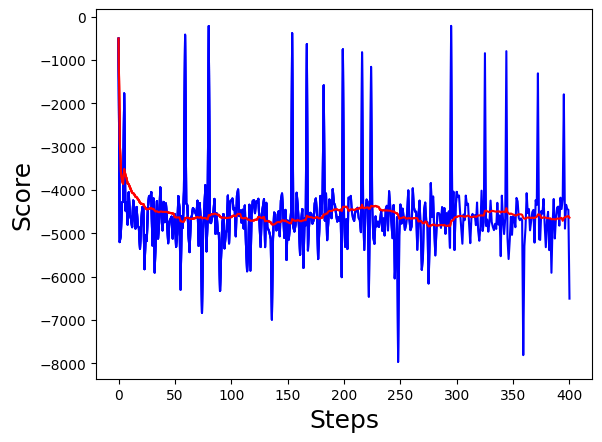

In [10]:
agent.run()